# Load in Data

In [2]:
from formulas import *
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

from pmdarima import auto_arima
import tensorflow as tf

keras = tf.keras

In [3]:
# Read data in to dataframes
spy = pd.read_csv('etfs/SPY.csv')
dia = pd.read_csv('etfs/DIA.csv')
qqq = pd.read_csv('etfs/QQQ.csv')


# Change date column to datetime type
spy['Date'] = pd.to_datetime(spy['Date'])
dia['Date'] = pd.to_datetime(dia['Date'])
qqq['Date'] = pd.to_datetime(qqq['Date'])

# View amount of daily data
print(f'There are {spy.shape[0]} rows in SPY and {dia.shape[0]} DIA rows')
print('*'*100)
print(f'''The date range of SPY is {spy.index.min()} to {spy.index.max()} 
       \n DIA is {dia.index.values.min()} to {dia.index.max()}
       \n QQQ is {qqq.index.min()} to {qqq.index.max()}''')

There are 6843 rows in SPY and 5587 DIA rows
****************************************************************************************************
The date range of SPY is 0 to 6842 
       
 DIA is 0 to 5586
       
 QQQ is 0 to 5300


In [4]:
spy.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,26.299288,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,26.486324,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,26.542448,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.822998,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.935240,531500


Text(0.5, 1.0, 'SPY Daily Adjust Close Price')

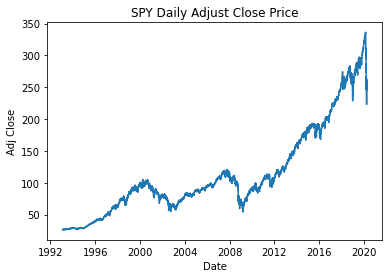

In [5]:
# Plot history of adjusted close price of SPY
sns.lineplot(x = spy.Date, y=spy['Adj Close'])
plt.title('SPY Daily Adjust Close Price')

## Create Train Test Split

### SPY Train Test Split

Here we can see our complete plot in terms of time steps. Our entire data set is just show of 7000 time steps. We know that our data is in days, so our data is just shy of 7000 daily observations. We need to separate out a training and validation set to see how our model holds up.

Using a traditional 80:20 train test split our train data will be from day 0 to day 5,474. Our validation set will be the remaining data.

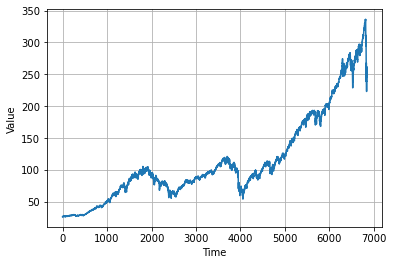

In [6]:
plot_series(time=spy.index,series=spy['Adj Close'])

In [7]:
# Set Split point at 80% of total data leaving the other 20% to be validation data
split_time = round(spy['Adj Close'].index.max() * .8)

# Print out to verify
print('Total days in training set =',split_time,'\n' + '*'*100)

# Create split in data using split point
time_train = spy.index[:split_time]
x_train = spy['Adj Close'][:split_time]

# Print tail to verify you are getting the last 
print('Training Set')
print(x_train.tail())

# Create time span and validation data for validation data now
time_valid = spy.index[split_time:]
x_valid = spy['Adj Close'][split_time:]

# Print out head of validationdata set to see if it picks up right where train set leaves off
print('*'*100)
print('Validation Set')
print(x_valid.head())


Total days in training set = 5474 
****************************************************************************************************
Training Set
5469    166.888809
5470    168.859909
5471    170.499496
5472    173.877258
5473    172.640823
Name: Adj Close, dtype: float64
****************************************************************************************************
Validation Set
5474    174.647720
5475    175.991669
5476    175.749771
5477    177.765656
5478    177.496872
Name: Adj Close, dtype: float64


In [8]:
# Lets create a dictionary to store all of our model training scores to view later
model_mae_scores = {}

# Base Model - Naive Forecasting

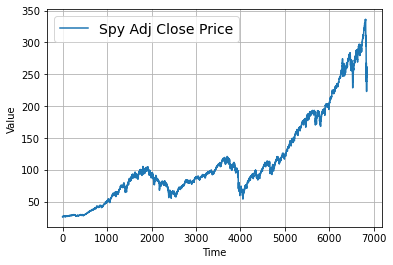

In [9]:
plot_series(time=spy.index,series=spy['Adj Close'], label = 'Spy Adj Close Price')

In [10]:
naive_forecast = spy['Adj Close'][split_time - 1:-1]

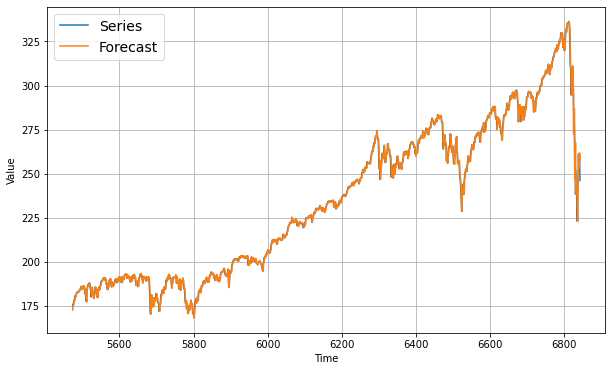

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, naive_forecast, label="Forecast")

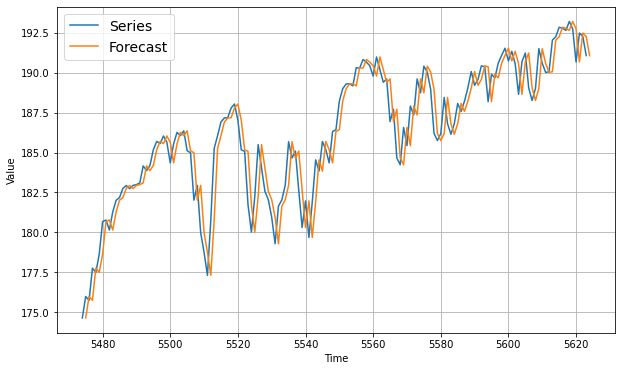

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

### Calculate Error in Naive Model

In [13]:
errors = naive_forecast.values - x_valid.values
abs_errors = np.abs(errors)
mae = abs_errors.mean()
mae

1.5437803414723057

In [14]:
# Alternative way to show MAE to stay consistent with what we will be doing later
naive_forecast_mae = keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()
naive_forecast_mae

1.5437803414723057

In [15]:
# Show first 3 values of our forecast
print(naive_forecast.values[:3])

# Show first 3 values of validation data
print(x_valid.values[:3])

# Calculate and show first 3 values of the calculated error (MAE)
print('*'*100)
print(np.abs(naive_forecast[:3].values - x_valid[:3].values))

[172.64082336 174.64772034 175.9916687 ]
[174.64772034 175.9916687  175.74977112]
****************************************************************************************************
[2.00689697 1.34394836 0.24189758]


### Add MAE score to our dictionary

In [16]:
model_mae_scores['Naive Forecast'] = naive_forecast_mae
model_mae_scores

{'Naive Forecast': 1.5437803414723057}

# Monthly Moving Average Model

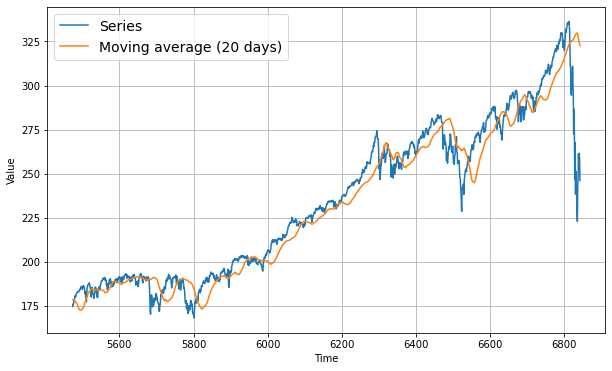

In [17]:
# Choose a window size for the moving average
window = 20

# Create a moving average over the entire dataset
moving_avg = spy['Adj Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[split_time - window:x_valid.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg_forecast, label="Moving average (20 days)")

In [18]:
ma_20 = keras.metrics.mean_absolute_error(x_valid, moving_avg_forecast).numpy()

model_mae_scores['20 Day Moving Average'] = ma_20
model_mae_scores

{'Naive Forecast': 1.5437803414723057,
 '20 Day Moving Average': 8.162007501684373}

# Weekly Moving Average

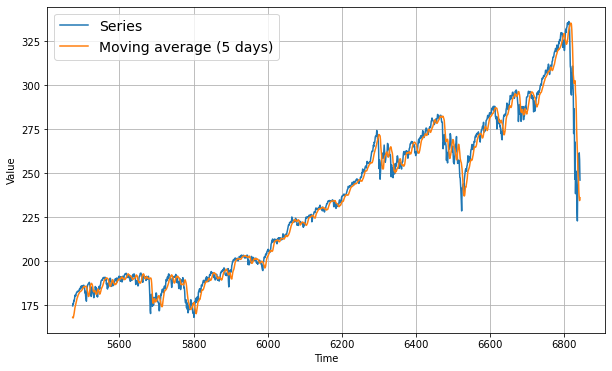

In [19]:
# Choose a window size for the moving average
window = 5

# Create a moving average over the entire dataset
moving_avg = spy['Adj Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[split_time - window:x_valid.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg_forecast, label="Moving average (5 days)")

In [20]:
# Calculate MAE
ma_5 = keras.metrics.mean_absolute_error(x_valid, moving_avg_forecast).numpy()

# Save to our dictionary of model mae scores
model_mae_scores['5 Day Moving Average'] = ma_5
model_mae_scores

{'Naive Forecast': 1.5437803414723057,
 '20 Day Moving Average': 8.162007501684373,
 '5 Day Moving Average': 3.888705627129319}

# ARIMA

### Step 1: Is the data stationary?

Use Augmented Dickey Fuller test to determine if the data is stationary
- Failure to reject the null hypothesis means the data is not stationary

In [23]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(spy['Adj Close'])
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')   

ADF Statistic: -0.12672569191370286
n_lags: 0.9467106273851426
p-value: 0.9467106273851426
Critial Values:
   1%, -3.4313092027856453
Critial Values:
   5%, -2.861963888809672
Critial Values:
   10%, -2.5669956322400047


The **p-value is obtained is greater than significance level of 0.05** and the **ADF statistic is higher than any of the critical values.**

Clearly, there is no reason to reject the null hypothesis. **So, the time series is in fact non-stationary.** Since our data is not statio

### Step 1.1 Differencing
We must convert our non-stationary data to stationary data using the differencing method. This means we take the value at time (t) and subtract the value at time (t-1) to get the difference.

In [24]:
# Get the difference of each Adj Close point
spy_close_diff_1 = spy['Adj Close'].diff()

# Drop nan values
spy_close_diff_1.dropna(inplace=True)

# Redo adfuller test with new data
result = adfuller(spy_close_diff_1)
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

ADF Statistic: -17.1542902062253
n_lags: 6.90917327304821e-30
p-value: 6.90917327304821e-30
Critial Values:
   1%, -3.4313092027856453
Critial Values:
   5%, -2.861963888809672
Critial Values:
   10%, -2.5669956322400047


The **p-value is obtained is less than significance level of 0.05** and the **ADF statistic is lower than any of the critical values.**

We reject the null hypothesis. **So, the time series is in fact stationary.** 

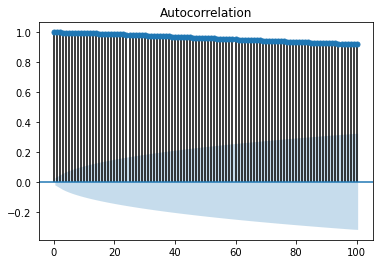

In [127]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(spy['Adj Close'], lags=100)
plt.show()

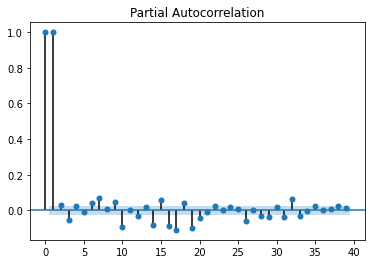

In [124]:
plot_pacf(spy['Adj Close'])
plt.show()

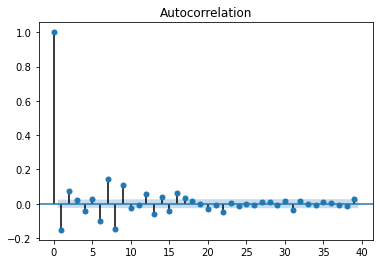

In [125]:
plot_acf(spy_close_diff_1)
plt.show()

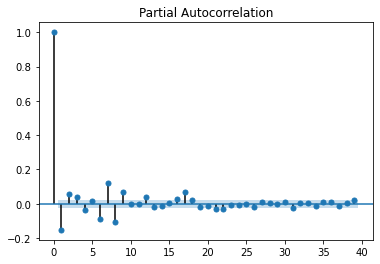

In [126]:
plot_pacf(spy_close_diff_1)
plt.show()

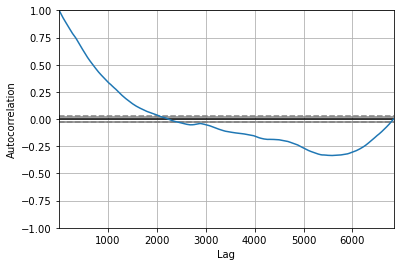

In [5]:
from pandas.plotting import autocorrelation_plot

# Plot autocorrelation for SPY
autocorrelation_plot(spy['Adj Close'])

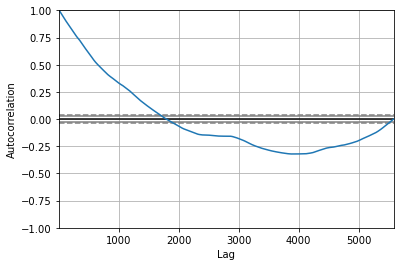

In [6]:
# Plot autocorrelation for DIA
autocorrelation_plot(dia['Adj Close'])

**Conlcusion**

- Seems to be positive until about 1750 day lag
- the earlier more recent the point the better the correlation
- No need to do anywhere the amount of lags we did. Need to focus earlier on

In [7]:
# Establish empty list for for-loop
spy_autocorr = []

# Loop through lag numbers to find the point with highest autocorrelation
for x in list(range(1,101)):
    spy_autocorr.append(spy['Adj Close'].autocorr(lag=x))

# Show the index of the point with the largest autocorrelation value
# 0 indexed so add 1 for correct number of lags
lags = spy_autocorr.index(max(spy_autocorr)) + 1 
print('The best performing lag is number {}'.format(lags))

The best performing lag is number 1


                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                 6842
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -12509.222
Method:                       css-mle   S.D. of innovations              1.506
Date:                Tue, 25 Aug 2020   AIC                          25024.445
Time:                        17:38:36   BIC                          25044.937
Sample:                             1   HQIC                         25031.514
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0324      0.016      2.051      0.040       0.001       0.063
ar.L1.D.Adj Close    -0.1541      0.012    -12.843      0.000      -0.178      -0.131
                        

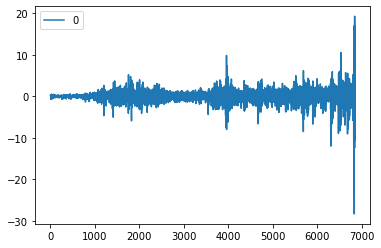

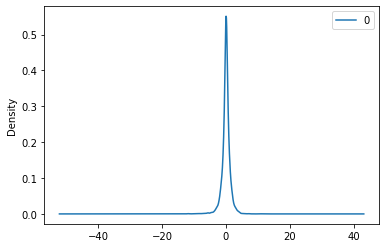

                 0
count  6842.000000
mean      0.000003
std       1.505962
min     -28.287488
25%      -0.459484
50%       0.035308
75%       0.543328
max      19.261323


In [92]:
from statsmodels.tsa.arima_model import ARIMA

# fit model
spy_model = ARIMA(spy['Adj Close'], order=(1,1,0))
spy_model_fit = spy_model.fit(disp=0)
print(spy_model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(spy_model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [81]:
residuals.drop(residuals.columns[0], axis=1, inplace=True)

In [107]:
np.abs(residuals[0][split_time - 1:]).mean()

1.541510343665383

In [21]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

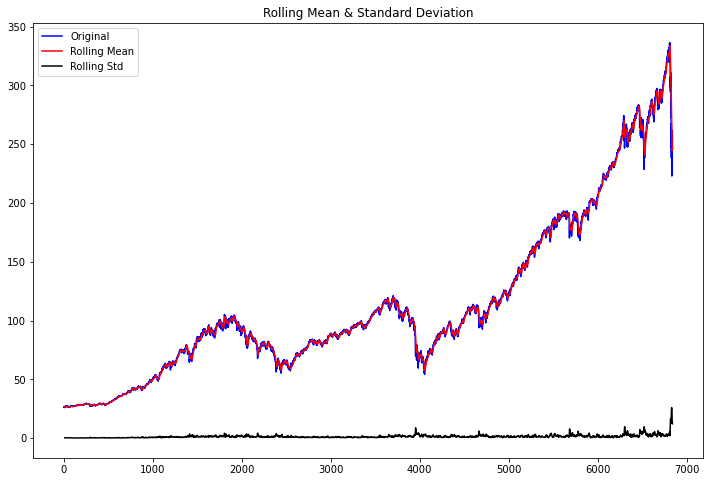

Results of Dickey-Fuller Test:
p-value = 0.9215. The series is likely non-stationary.
Test Statistic                   -0.327558
p-value                           0.921510
#Lags Used                       20.000000
Number of Observations Used    6822.000000
Critical Value (1%)              -3.431309
Critical Value (5%)              -2.861964
Critical Value (10%)             -2.566996
dtype: float64


In [25]:
test_stationarity(spy['Adj Close'])

In [108]:
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(spy['Adj Close'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 365, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True,
                          n_jobs=-1)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

C:\Users\blake\Anaconda3\lib\site-packages\pmdarima\arima\_validation.py:75: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Performing stepwise search to minimize aic


KeyboardInterrupt: 

# RNN Model

# LSTM Model

# CNN - Wavenet Model